# Fundamentals of Machine Learning - Exercise 6
Dominique Cheray & Manuel Krämer

In [1]:
import numpy as np
from scipy.sparse import linalg
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.ndimage.filters import gaussian_filter
import random
from sklearn.datasets import load_digits
from sklearn import model_selection
from matplotlib import colors
from sklearn.metrics import confusion_matrix

## Bias and variance of ridge regression
Only included in the PDF file

## Denoising of a CT image

In [2]:
def construct_X(M, alphas, Np=None, tau=0):
    if not Np:
        Np = np.ceil(np.sqrt(2) * M).astype(int)
    if Np % 2 == 0:
        Np += 1
    D = M * M
    No = len(alphas)
    N = Np * No
    C1 = (np.mgrid[0:M, 0:M][0]).flatten()
    C2 = (np.mgrid[0:M, 0:M][1]).flatten()
    C = np.vstack((C1, C2))
    # centralise the coordinates in C
    C = C - (M - 1) / 2
    # convert alphas to radian
    alphas_rad = np.radians(alphas)
    # now make vectors out of the angles
    n = np.zeros((2, No))
    n[0] = -np.sin(alphas_rad)
    n[1] = np.cos(alphas_rad)
    p = n.T.dot(C) + (Np - 1) / 2
    lower_element = np.floor(p).astype(int)
    upper_element = np.ceil(p).astype(int)
    lower_value = upper_element - p
    upper_value = p - lower_element
    weights = []
    i_indices = []
    j_indices = []
    for i in range(No):
        for j in range(len(lower_element[i])):
            if (lower_element[i][j] == upper_element[i][j]):
                weights.append(1)
                i_indices.append(i*Np+lower_element[i][j])
                j_indices.append(j)
            else:
                weights.append(lower_value[i][j])
                i_indices.append((i*Np+lower_element[i][j]))
                j_indices.append(j)
                weights.append(upper_value[i][j])
                i_indices.append(((i*Np+upper_element[i][j])))
                j_indices.append(j)
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)
    # if tau is given construct the diagonal matrix and append it to X
    if tau != 0:
        x_indices = np.arange(D)
        y_indices = np.arange(D)
        taus = np.full((D), np.sqrt(tau))
        tauMatrix = coo_matrix((taus, (x_indices, y_indices)), shape=(D, D), dtype=np.float32)
        X = scipy.sparse.vstack((X, tauMatrix))
    return X


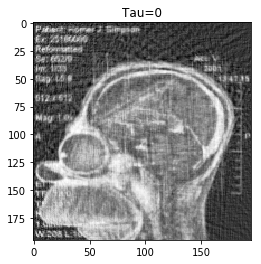

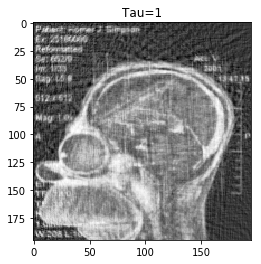

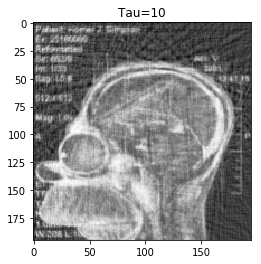

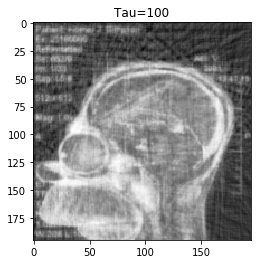

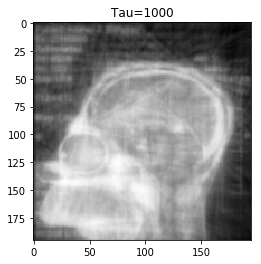

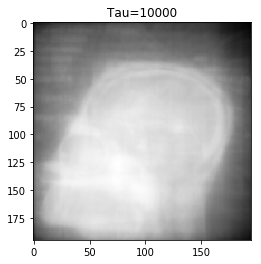

In [3]:
alphas = np.load('hs_tomography/alphas_195.npy')
y = np.load('hs_tomography/y_195.npy')
Np = 275
M = 195
newy = np.array([])
No = len(alphas)
# out of all alphas draw 64 at random
randalphas = random.sample(range(0, No), 64)
newalphas = []
for i in randalphas:
    newalphas.append(alphas[i])
    data = y[np.arange(i*Np, i*Np+Np)]
    newy = np.concatenate((newy, data))

# don't include tau=0 it will be handede separately because
# the image is needed later for the gaussian filtering
taus = [1, 10, 100, 1000, 10000]
# now start with tau = 0
X = construct_X(M, newalphas, Np, 0)
X_csc = X.tocsc()
img_tau_zero = linalg.lsqr(X_csc, newy, atol=1e-05, btol=1e-05)
img_tau_zero = img_tau_zero[0]
img_tau_zero = img_tau_zero.reshape((M, M))
plt.imshow(img_tau_zero, cmap=plt.cm.Greys_r)
plt.title('Tau=0')
plt.show()

# now construct a new y vector with zeros appendend 
# for the cases where tau is not zero
zeros = np.zeros(M*M)
newy = np.concatenate((newy, zeros))
for tau in taus:
    X = construct_X(M, newalphas, Np, tau)
    X_csc = X.tocsc()
    img = linalg.lsqr(X_csc, newy, atol=1e-05, btol=1e-05)
    img = img[0]
    img = img.reshape((M, M))
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.title('Tau=%i' %(tau))
    plt.show()

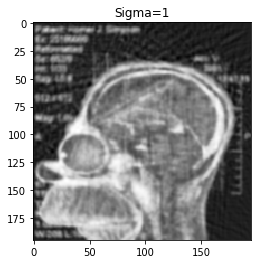

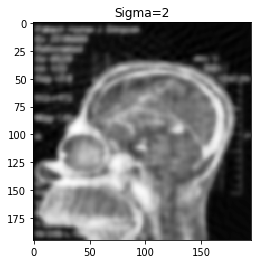

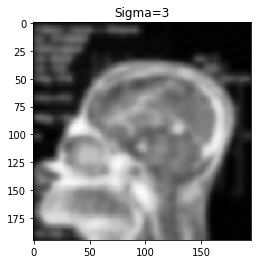

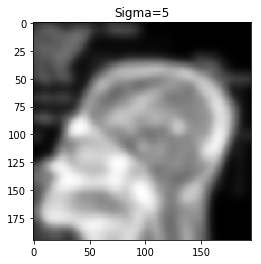

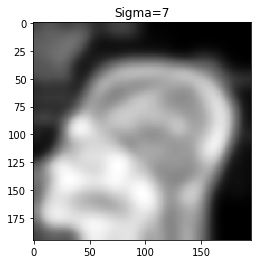

In [4]:
# now do the Gaussian filtering
sigmas = [1, 2, 3, 5, 7]
for sigma in sigmas:
    filtered_image = gaussian_filter(img_tau_zero, sigma)
    plt.imshow(filtered_image, cmap=plt.cm.Greys_r)
    plt.title('Sigma=%i' % sigma)
    plt.show()

For both methods increasing tau respectively sigma improves the result only until a certain level later on the images get worse. For Gaussian filtering the image already starts to get blurrier when sigma is increased to 2. Using the ridge regression the image gets worse when increasing tau to 1000. The Gaussian filtering reduces the noise more than the Ridge Regression, but also looses contrast. The Ridge Regression images stay relatively sharp but at some point the lighter parts of the image seam smeared all over the image. 

## Automatic feature selection for regression
### Implement Orthogonal Matching Pursuit

In [5]:
def omp_regression(X, y, T):
    if T > X.shape[1]:
        T = X.shape[1]
    A = []
    B = list(range(0, X.shape[1]))
    residual = y
    # matrix to return filled with zeros
    betaMatrix = np.zeros((X.shape[1], T))
    for t in range(T):
        inactiveX = X[:, B]
        # get index of column having maximal correlation
        # with current residual
        j_index = np.argmax(inactiveX.T.dot(residual))
        # get corresponding j from list of inactive columns
        j = B[j_index]
        A.append(j)
        B.remove(j)
        activeX = X[:, A]
        beta = np.linalg.lstsq(activeX, y)[0]  # (activeX, y, atol=1e-05, btol=1e-05)[0]
        residual = y - activeX.dot(beta)
        # put non-zero elements for this iteration into
        # matrix to return
        betaMatrix[A, t] = beta
    return betaMatrix

### Classification with sparse LDA

In [6]:
digits = load_digits()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
# filter data for 1 and 7
filter_mask = (target == 1) | (target == 7)
data = data[filter_mask]
images = images[filter_mask]
target = target[filter_mask]
# standardize the data
std = np.std(data, axis=0)
std = np.expand_dims(std, axis=0)
mean = np.mean(data, axis=0)
mean = np.expand_dims(mean, axis=0)
# if std is zero change it to 1 avoid dividing by 0
std[std == 0] = 1
data = (data - mean) / std
# now change target vector to the given desired response
# 1 if instance is a 1 and -1 if instance is a 7
target[target == 7] = -1
# split in train and testset
x_train, x_test, y_train, y_test = model_selection.train_test_split(data,
                                                                    target,
                                                                    test_size=0.33,
                                                                    random_state=0)
betaMat = omp_regression(x_train, y_train, 64)
# for every test instance and every t caculate
# X*betaMat
classification = x_test.dot(betaMat)
# a negative response means class seven
classification[classification < 0] = -1
# a positive response means class 1
classification[classification >= 0] = 1
# now calculate the error rate for every t
num_test_instances = x_test.shape[0]
for i in range(classification.shape[1]):
    wrong_elems = np.sum(classification[:, i] != y_test)
    error_rate = wrong_elems / num_test_instances * 100
    print('Error rate for t=%i is: %d%%' % ((i+1), error_rate))

Error rate for t=1 is: 3%
Error rate for t=2 is: 0%
Error rate for t=3 is: 0%
Error rate for t=4 is: 0%
Error rate for t=5 is: 0%
Error rate for t=6 is: 0%
Error rate for t=7 is: 0%
Error rate for t=8 is: 0%
Error rate for t=9 is: 0%
Error rate for t=10 is: 0%
Error rate for t=11 is: 0%
Error rate for t=12 is: 0%
Error rate for t=13 is: 0%
Error rate for t=14 is: 0%
Error rate for t=15 is: 0%
Error rate for t=16 is: 0%
Error rate for t=17 is: 0%
Error rate for t=18 is: 0%
Error rate for t=19 is: 0%
Error rate for t=20 is: 0%
Error rate for t=21 is: 0%
Error rate for t=22 is: 0%
Error rate for t=23 is: 0%
Error rate for t=24 is: 0%
Error rate for t=25 is: 0%
Error rate for t=26 is: 0%
Error rate for t=27 is: 0%
Error rate for t=28 is: 0%
Error rate for t=29 is: 0%
Error rate for t=30 is: 0%
Error rate for t=31 is: 0%
Error rate for t=32 is: 0%
Error rate for t=33 is: 0%
Error rate for t=34 is: 0%
Error rate for t=35 is: 0%
Error rate for t=36 is: 0%
Error rate for t=37 is: 0%
Error rate

For standardized data 2 pixels are enough to distinguish the two classes and get an test error of 0%. If the data is not standardized the classifier needs 19 pixels to classify less than 50% wrong and 32 pixels to classifiy less than 10% wrong.

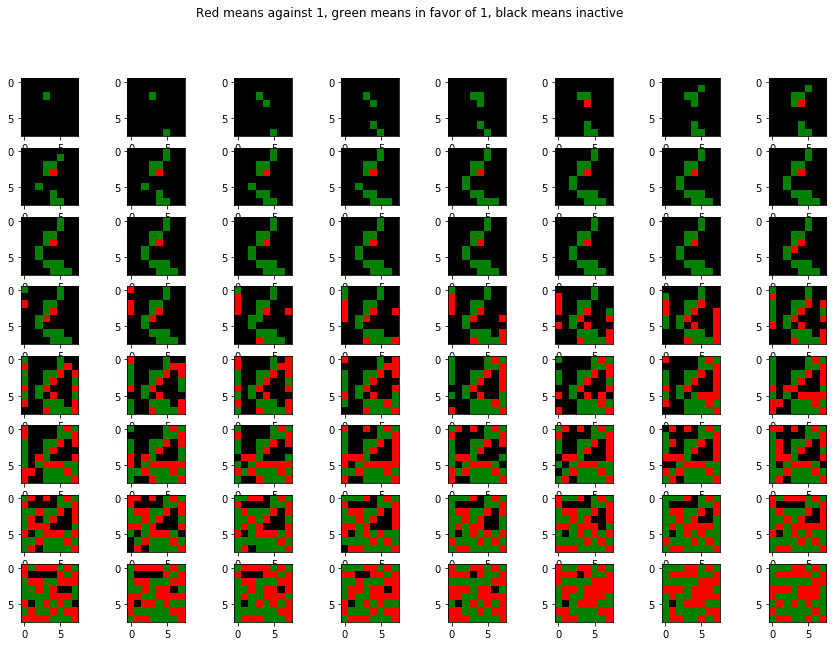

In [7]:
visualize_beta = omp_regression(x_train, y_train, 64)
visualize_beta[visualize_beta < 0] = -1
visualize_beta[visualize_beta > 0] = 1
# make a color map of fixed colors 
cmap = colors.ListedColormap(['red', 'black', 'green'])
bounds = [-1,-0.5,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
fig, axes = plt.subplots(8,8, figsize=(15,10))
axes = axes.ravel()
plt.suptitle('Red means against 1, green means in favor of 1, black means inactive')
for i in range(0, 64):
    axes[i].imshow(visualize_beta[:, i].reshape((8,8)), cmap=cmap, norm=norm)
plt.show()

Pixels with negative weight vote against class 1 pixels with positive weight vote in favor of class one. The first two pixels that get activated are 19 and 61. In our handcrafted solution we chose pixels 19 and 60 so we are pretty close to the features selected by the sparse LDA.

### One-against-the-rest classification

Confusion matrix. Classes are: 
 -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0 48  0  0  0  0  0  1  0  0  0]
 [ 0  0 50  0  1  2  1  3  0  1  3]
 [ 0  1  3 50  4  0  0  0  0  4  0]
 [ 0  0  0  1 46  0  1  1  1  2  3]
 [ 0  0  4  0  0 43  0  0  1  2  0]
 [ 0  0  1  0  0  0 59  1  0  0  4]
 [ 0  0  0  1  0  0  0 65  0  1  0]
 [ 0  0  2  0  4  1  0  0 49  0  0]
 [ 1  0  7  1  0  0  0  1  1 53  3]
 [ 1  0  0  0  1  0  0  0  0  3 57]]


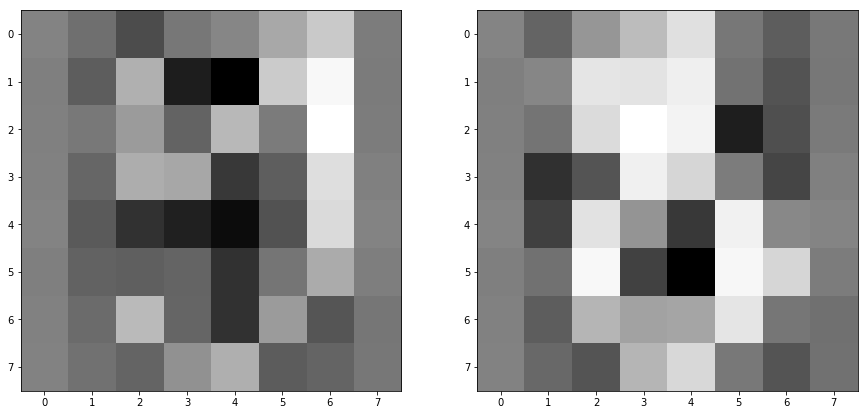

In [8]:
# fix random seed for reproducible results
random.seed(0)
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
# standardize the data
std = np.std(data, axis=0)
std = np.expand_dims(std, axis=0)
mean = np.mean(data, axis=0)
mean = np.expand_dims(mean, axis=0)
# if std is zero change it to 1 avoid dividing by 0
std[std == 0] = 1
data = (data - mean) / std
# split in train and testset
x_train, x_test, y_train, y_test = model_selection.train_test_split(data,
                                                                    target,
                                                                    test_size=0.33,
                                                                    random_state=0)
B = []
# for every class train a classifier
for k in range(10):
    # get all labels of target class
    sample_target = y_train[y_train == k]
    # get number of instances in target class
    N = len(sample_target)
    # get all instances of target class
    sample = x_train[y_train == k]
    # get all other classes
    rest = x_train[y_train != k]
    # now choose randomly N elements from the other classes
    rand = random.sample((range(0, len(rest))), N)
    # get the instances and labels of the other classes
    rest = rest[rand]
    rest_target = y_train[y_train != k]
    rest_target = rest_target[rand]
    # plug target class and the rest together
    sample = np.vstack((sample, rest))
    # plug the labels together
    sample_target = np.concatenate((sample_target, rest_target))
    # change labels to desired responses
    # 1 for target class, -1 for the others
    sample_target[sample_target != k] = -1
    sample_target[sample_target == k] = 1
    # now get the betas from the omp_regression
    b = omp_regression(sample, sample_target, 64)
    # only keep the last beta
    B.append(b[:, 63])
B = np.asarray(B)

# Testing 
# empty list for all predictions of the classifiers
predict = []
# for every instance in the testset
for k in range(x_test.shape[0]):
    # get prediction of all classifiers
    y = B.dot(x_test[k, :].T)
    predict.append(y)
# check which classifier has the highest respons
predicted_label = np.argmax(predict, axis=1)
# now check if for an instance all responses were
# negative and if so assign the instance to class
# unknown
max = np.max(predict, axis=1)
predicted_label[max < 0] = -1
# print the confusion matrix 
print('Confusion matrix. Classes are: \n -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9')
print(confusion_matrix(y_test, predicted_label))
# get the indeces of the instances classified as unknwon
minus_ones = np.where(predicted_label == -1)[0]
# get the corresponding images
unknown_images = x_test[minus_ones]
nr_subplots = unknown_images.shape[0]
fig, axes = plt.subplots(1,nr_subplots, figsize=(15,10))
axes = axes.ravel()
for i in range(unknown_images.shape[0]):
    axes[i].imshow(unknown_images[i, :].reshape((8,8)), cmap=plt.cm.Greys_r)
plt.show()

Class unknown avoids the situation that an instance is assigned to a class even though all classifiers have negative response meaning that the instance probably does not belong to any of the known classes. Visualizing the images classified as unknwon one clearly sees that they hardly resemble any number and thus can not be classified.